In [1]:
import cv2 as cv
import math
from matplotlib import pyplot as plt
from PIL import Image

# Function definitions


In [5]:
#gamma is the angle between the ray of the principal point and the ray of the imaged point projected 
#on a plane O orthogonal to the ground and the image plane
def calc_gamma(principal_point_y, image_point_y, f):
  #the angle of the ray defined by the image point wrt camera height
  gamma = math.asin((principal_point_y - image_point_y) / (math.sqrt(f**2 + (principal_point_y - image_point_y)**2)))
  gamma = (gamma / math.pi) * 180
  return gamma

In [6]:
#camera angle wrt to the height of the camera
def calc_camera_angle(height, base):
  #camera distance from road along principal axis
  ipo = math.sqrt(base**2 + height**2)#meters
  #camera inclication wrt road plane
  camera_angle = math.acos(height / ipo)
  camera_angle = (camera_angle / math.pi) * 180
  return camera_angle

In [7]:
#first component of the distance of image point projected on the road
def calc_z(camera_angle, gamma, height):
  alpha = camera_angle + gamma #in degrees
  # print('alpha ', alpha)
  alpha = alpha /180 * math.pi
  Z = height / math.cos(alpha)
  return Z

In [8]:
#alpha is the angle between the image ray of the image point projected on the O plane and the original ray
def calc_alpha(principal_point_x, image_point_x, f):
  delta_x = principal_point_x - image_point_x
  
  tan_alpha = delta_x / f
  alpha = math.atan(tan_alpha) # radians
  alpha = alpha / math.pi * 180 # degrees
  # print(delta_x, alpha)
  return alpha

In [9]:
#distance of the image point projection on the road from the camera centre
def calc_z_prime(z, alpha):
  alpha = alpha / 180 * math.pi
  z_prime = z / math.cos(alpha)
  return z_prime

In [10]:
#distance of the image point projection on the road from the image plane along the road plane
def calc_distance(z_prime, camera_angle):
  delta = 90 - camera_angle #camera angle should be in degrees, here delta is in degrees as well
  delta = delta / 180 * math.pi #convert to radians
  distance = z_prime / math.cos(delta) #in meters
  return distance

# calculate partial depth map

In [11]:
video_path = '/content/drive/MyDrive/vision/senza_ombre_motog5.mp4'
capture = cv.VideoCapture(video_path)
ret, frame = capture.read()
if not ret:
  print('error')

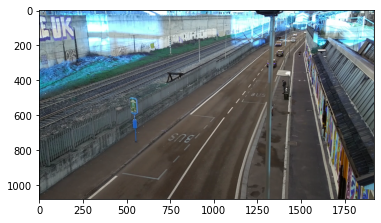

In [12]:
plt.imshow(frame)

In [14]:
principal_point_y = 1080/2
height = 8.5 #meters
distance = 30 #meters
distances = []
f = 1711.8
for i in range(10):
  y = (i+1) * 100
  gamma = calc_gamma(principal_point_y, y,f)
  camera_angle = calc_camera_angle(height, distance)
  z = calc_z(camera_angle, gamma, height)
  print(y, gamma, z)
  distances.append(z)

100 14.415211562657834 346.91522672066753
200 11.233958791358262 106.3270118607973
300 7.981034097201127 62.32795868471027
400 4.6755438475878215 43.980039013293116
500 1.3385992425522781 33.992917049940566
600 -2.0074424473071164 27.76526435395445
700 -5.339857013450058 23.54843628704643
800 -8.636468807268228 20.53194836550357
900 -11.876512026875883 18.2883920281139
1000 -15.041356977007487 16.570804925807614


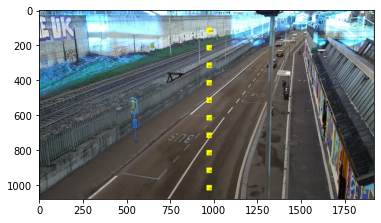

In [15]:
copy = frame.copy()
for i in range(10):
  y = (i+1) * 100
  cv.rectangle(copy, (960, y), (960 + 30, y+30), (255,255,0), -1)
  cv.putText(copy, str(int(distances[i])), (960+10, y+25),
              cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
  # break
plt.imshow(copy)
image = Image.fromarray(copy)
image.save('distances.png')

# calculate full depth map

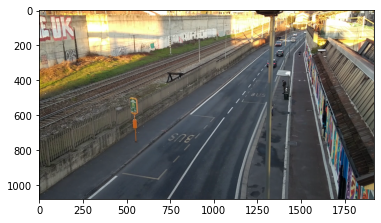

In [16]:
video_path = '/content/drive/MyDrive/vision/senza_ombre_motog5.mp4'
capture = cv.VideoCapture(video_path)
ret, frame = capture.read()
if not ret:
  print('error')
# frame = cv.rotate(frame, cv.ROTATE_90_CLOCKWISE)
frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
plt.imshow(frame)
image = Image.fromarray(frame)
image.save('frame.png')

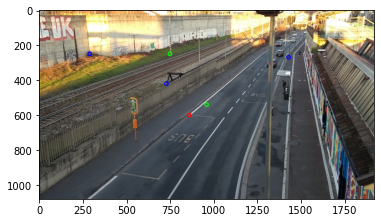

In [19]:
copy = frame.copy()
cv.circle(copy, (860, 600), 10, (255,0,0), 5)#measured point
cv.circle(copy, (960, 540), 10, (0,255,0), 5)#image centre
cv.circle(copy, (730, 420), 10, (0,0,255), 5)#rail stop
cv.circle(copy, (290, 250), 10, (0,0,255), 5)#wall corner //bad point(not at road level)
cv.circle(copy, (1430, 270), 10, (0,0,255), 5)#terzo lampione
cv.circle(copy, (750, 250), 10, (0,255,0), 5)#palo sinistra
plt.imshow(copy)

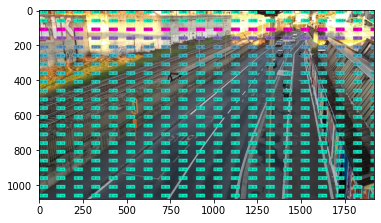

In [20]:
principal_point = (960, 540)
principal_point = (960, 540)
height = 8.5
f = 1711.8
base = 30
camera_angle = calc_camera_angle(height, base)
copy = frame.copy()

for x in range(20):
  # x = x + 1
  for y in range(23):
    # y = y + 1
    im_x = 100*x
    im_y = 50*y
    image_point = (im_x, im_y)
    gamma = calc_gamma(principal_point[1], image_point[1], f)
    # print(gamma)
    z = calc_z(camera_angle, gamma, height)
    alpha = calc_alpha(principal_point[0], image_point[0], f)
    # print('alpha= ', alpha)
    z_prime = calc_z_prime(z, alpha)
    color = (255*(z_prime/300), 255*(1-(z_prime/300)), 200)
    cv.rectangle(copy, (im_x, im_y), (im_x+50, im_y+20), color, -1)
    cv.putText(copy, str(int(z_prime))+' m', (im_x, im_y+15),
              cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
  # break
plt.imshow(copy)
image = Image.fromarray(copy)
image.save('distances.png')

print values for selected points for validation

In [21]:
# principal_point = (860, 600)
principal_point = (960, 540)
height = 8.5
f = 1711.8
base = 30
camera_angle = calc_camera_angle(height, base)
def partial_wrapper(principal_point, image_point, f, height):
  gamma = calc_gamma(principal_point[1], image_point[1], f)
  z = calc_z(camera_angle, gamma, height)
  return z
def wrapper(principal_point, image_point, f, height):
  gamma = calc_gamma(principal_point[1], image_point[1], f)
  z = calc_z(camera_angle, gamma, height)
  alpha = calc_alpha(principal_point[0], image_point[0], f)
  z_prime = calc_z_prime(z, alpha)
  d = calc_distance(z_prime, camera_angle)
  return d
print('image centre ', partial_wrapper(principal_point, (960, 540), f, height), wrapper(principal_point, (960, 540), f, height))
print('rail stop ', partial_wrapper(principal_point, (732, 417), f, height), wrapper(principal_point, (732, 417), f, height))
print('measured point ', partial_wrapper(principal_point, (860, 600), f, height) ,wrapper(principal_point, (860, 600), f, height))
print('bus close ', partial_wrapper(principal_point, (680, 966), f, height) ,wrapper(principal_point, (680, 966), f, height))
print('bus far ', partial_wrapper(principal_point, (1003, 612), f, height) ,wrapper(principal_point, (1003, 612), f, height))
print('horizon ', partial_wrapper(principal_point, (1500, 55), f, height) ,wrapper(principal_point, (1500, 55), f, height))
print('palo des', partial_wrapper(principal_point, (1431, 273), f, height) ,wrapper(principal_point, (1431, 273), f, height))
print('palo sin ', partial_wrapper(principal_point, (754, 255), f, height) ,wrapper(principal_point, (754, 255), f, height))
print('angolo edificio des ', partial_wrapper(principal_point, (1558, 465), f, height) ,wrapper(principal_point, (1558, 465), f, height))
print('palo vicino ', partial_wrapper(principal_point, (1211, 343), f, height) ,wrapper(principal_point, (1211, 343), f, height))

image centre  31.180923655337732 32.40833333333334
rail stop  41.882958712749634 43.91608168965089
measured point  27.76526435395445 28.90741941486928
bus close  17.10664416961455 18.016317310707013
bus far  27.174433449223685 28.253040807615193
horizon  1571834.1666802967 1713068.4046795014
palo des 70.2074009287198 75.68287212690794
palo sin  76.6523077229535 80.2444726730739
angolo edificio des  36.919997384060814 40.647443215916375
palo vicino  52.85537633960654 55.52340697463101


show the values calculated above on the image

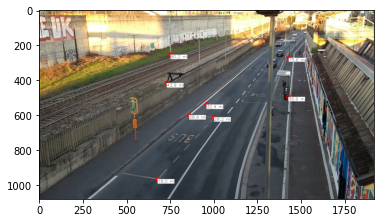

In [22]:
copy = frame.copy()
cv.circle(copy, (960, 540), 10, (255,0,0), 5)
cv.rectangle(copy, (960, 540), (1055, 565), (255,255,255), -1)
cv.putText(copy, str(wrapper(principal_point, (960, 540), f, height))[0:4]+' m', (960, 560),
          cv.FONT_HERSHEY_SIMPLEX, 0.8 , (0,0,0))

cv.circle(copy, (732, 417), 10, (255,0,0), 5)
cv.rectangle(copy, (732, 417), (827, 442), (255,255,255), -1)
cv.putText(copy, str(wrapper(principal_point, (732, 417), f, height))[0:4]+' m', (732, 437),
          cv.FONT_HERSHEY_SIMPLEX, 0.8 , (0,0,0))

cv.circle(copy, (860, 600), 10, (255,0,0), 5)
cv.rectangle(copy, (860, 600), (955, 625), (255,255,255), -1)
cv.putText(copy, str(wrapper(principal_point, (860, 600), f, height))[0:4]+' m', (860, 620),
          cv.FONT_HERSHEY_SIMPLEX, 0.8 , (0,0,0))

cv.circle(copy, (1431, 273), 10, (255,0,0), 5)
cv.rectangle(copy, (1431, 273), (1526, 295), (255,255,255), -1)
cv.putText(copy, str(wrapper(principal_point, (1431, 273), f, height))[0:4]+' m', (1431, 293),
          cv.FONT_HERSHEY_SIMPLEX, 0.8 , (0,0,0))

cv.circle(copy, (680, 966), 10, (255,0,0), 5)
cv.rectangle(copy, (680, 966), (775, 991), (255,255,255), -1)
cv.putText(copy, str(wrapper(principal_point, (680, 966), f, height))[0:4]+' m', (680, 986),
          cv.FONT_HERSHEY_SIMPLEX, 0.8 , (0,0,0))

cv.circle(copy, (1003, 612), 10, (255,0,0), 5)
cv.rectangle(copy, (1003, 612), (1098, 637), (255,255,255), -1)
cv.putText(copy, str(wrapper(principal_point, (1003, 612), f, height))[0:4]+' m', (1003, 632),
          cv.FONT_HERSHEY_SIMPLEX, 0.8 , (0,0,0))

cv.circle(copy, (1429, 496), 10, (255,0,0), 5)
cv.rectangle(copy, (1429, 496), (1429+95, 496+25), (255,255,255), -1)
cv.putText(copy, str(wrapper(principal_point, (1429, 496), f, height))[0:4]+' m', (1429, 496+20),
          cv.FONT_HERSHEY_SIMPLEX, 0.8 , (0,0,0))

cv.circle(copy, (754, 255), 10, (255,0,0), 5)
cv.rectangle(copy, (754, 255), (849, 280), (255,255,255), -1)
cv.putText(copy, str(wrapper(principal_point, (754, 255), f, height))[0:4]+' m', (754, 275),
          cv.FONT_HERSHEY_SIMPLEX, 0.8 , (0,0,0))

plt.imshow(copy)